In [16]:
!pip install aif360;
!pip install fairlearn;
!pip install 'aif360[AdversarialDebiasing]'

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, plot_roc_curve, recall_score, precision_score

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder

from aif360.datasets import CompasDataset
from aif360.sklearn.datasets import fetch_compas
from aif360.algorithms.inprocessing import MetaFairClassifier

from aif360.sklearn.preprocessing import ReweighingMeta
from aif360.sklearn.inprocessing import AdversarialDebiasing
from aif360.sklearn.postprocessing import CalibratedEqualizedOdds, PostProcessingMeta
from aif360.sklearn.datasets import fetch_german
from aif360.sklearn.metrics import disparate_impact_ratio, average_odds_error, generalized_fpr, average_odds_difference
from aif360.sklearn.metrics import generalized_fnr, difference, statistical_parity_difference, equal_opportunity_difference, generalized_entropy_error

from IPython.display import Markdown, display

In [18]:
Data = pd.read_csv("https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-raw.csv")
Data.head()

,Person_ID,AssessmentID,Case_ID,Agency_Text,LastName,FirstName,MiddleName,Sex_Code_Text,Ethnic_Code_Text,DateOfBirth,...,RecSupervisionLevel,RecSupervisionLevelText,Scale_ID,DisplayText,RawScore,DecileScore,ScoreText,AssessmentType,IsCompleted,IsDeleted
0,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,1,Low,7,Risk of Violence,-2.08,4,Low,New,1,0
1,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,1,Low,8,Risk of Recidivism,-1.06,2,Low,New,1,0
2,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,1,Low,18,Risk of Failure to Appear,15.00,1,Low,New,1,0
3,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,...,1,Low,7,Risk of Violence,-2.84,2,Low,New,1,0
4,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,...,1,Low,8,Risk of Recidivism,-1.50,1,Low,New,1,0


In [19]:
#@title Confusion matrix and Visualisation plots

# Function for visualising the confusion matrix and other statistics
# https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py

def make_confusion_matrix(cf_matrix, model):
  group_names = ["True Negative","False Positive","False Negative","True Positive"]
  group_counts = ["{0:0.0f}".format(value) for value in
                  cf_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in
                      cf_matrix.flatten()/np.sum(cf_matrix)]

  group_labels = ["{}\n".format(value) for value in group_names]
  group_counts = ["{0:0.0f}\n".format(value) for value in cf_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

  box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
  box_labels = np.asarray(box_labels).reshape(cf_matrix.shape[0],cf_matrix.shape[1])


  # add more statistics
  accuracy  = np.trace(cf_matrix) / float(np.sum(cf_matrix))
  precision = cf_matrix[1,1] / sum(cf_matrix[:,1])
  recall    = cf_matrix[1,1] / sum(cf_matrix[1,:])
  f1_score  = 2*precision*recall / (precision + recall)
  stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
      accuracy,precision,recall,f1_score)


  categories=["Bad creadit", "Good credit"]
  sns.heatmap(cf_matrix,annot=box_labels,fmt="",cmap='Purples',xticklabels=categories,yticklabels=categories)

  plt.ylabel('True label')
  plt.xlabel('Predicted label' + stats_text)
  plt.title(f"Confusion matrix and statistics for the {model} model");

def metrics_per_group(y_test, y_pred):
	# y true per group
	y_test_male = y_test.loc[y_test.index.get_level_values(1) == 1]
	y_test_female = y_test.loc[y_test.index.get_level_values(1) == 0]

	# y_pred per group
	y_pred_male = y_pred[y_test.index.get_level_values(1) == 1]
	y_pred_female = y_pred[y_test.index.get_level_values(1) == 0]

	# metrics
	scores = []
	scores.append(accuracy_score(y_test, y_pred))
	scores.append(recall_score(y_test, y_pred))
	scores.append(precision_score(y_test, y_pred))

	scores.append(accuracy_score(y_test_female, y_pred_female))
	scores.append(recall_score(y_test_female, y_pred_female))
	scores.append(precision_score(y_test_female, y_pred_female))

	scores.append(accuracy_score(y_test_male, y_pred_male))
	scores.append(recall_score(y_test_male, y_pred_male))
	scores.append(precision_score(y_test_male, y_pred_male))

	attribute = ["all"]*3 + ["female"] *3 + ["male"] *3
	metric = ["accuracy", "recall", "precision"] * 3
	  
	# dictionary of lists 
	dict = {'gender': attribute, 'metrics': metric, 'score': scores} 
	    
	df = pd.DataFrame(dict)

	sns.barplot(x = "metrics", y = "score", hue = "gender", data = df, palette = ['#dfcd1a', '#9d0677', '#236c48'])
	plt.title("Performance metrics by groups")
 

def plot_fair_metrics(fair_metrics_mitigated, model): 
  cols = ['statistical_parity_difference', 'equal_opportunity_difference', 'generalized_entropy']
  obj_fairness = [[0,0,1]]

  # row for objectives    
  fair_metrics = pd.DataFrame(data=obj_fairness, index=['objective'], columns=cols)
      
  # row for baseline model
  fair_metrics.loc['Baseline Model'] = [stat_par_diff, eq_opp_diff, gen_entr_error]

  # row for mitigated bias
  fair_metrics.loc[model] = fair_metrics_mitigated


  metrics_len = len(cols)


  fig, ax = plt.subplots(figsize=(20,4), ncols=metrics_len, nrows=1)

  plt.subplots_adjust(
      left    =  0.125, 
      bottom  =  0.1, 
      right   =  0.9, 
      top     =  0.9, 
      wspace  =  .5, 
      hspace  =  1.1
  )

  y_title_margin = 1.2

  plt.suptitle("Fairness metrics", y = 1.09, fontsize=20)
  sns.set(style="dark")

  cols = fair_metrics.columns.values
  obj = fair_metrics.loc['objective']
  size_rect = [0.2,0.2,0.2,0.4,0.25]
  rect = [-0.1,-0.1,-0.1,0.8,0]
  bottom = [-1,-1,-1,0,0]
  top = [1,1,1,2,1]
  bound = [[-0.1,0.1],[-0.1,0.1],[-0.1,0.1],[0.8,1.2],[0,0.25]]

  for i in range(0,metrics_len):
      plt.subplot(1, metrics_len, i+1)
      ax = sns.barplot(x=fair_metrics.index[1:len(fair_metrics)], y=fair_metrics.iloc[1:len(fair_metrics)][cols[i]])
      
      for j in range(0,len(fair_metrics)-1):
          a, val = ax.patches[j], fair_metrics.iloc[j+1][cols[i]]
          marg = -0.2 if val < 0 else 0.1
          ax.text(a.get_x()+a.get_width()/5, a.get_y()+a.get_height()+marg, round(val, 3), fontsize=15,color='black')

      plt.ylim(bottom[i], top[i])
      plt.setp(ax.patches, linewidth=0)
      ax.add_patch(patches.Rectangle((-5,rect[i]), 10, size_rect[i], alpha=0.3, facecolor="green", linewidth=1, linestyle='solid'))
      plt.axhline(obj[i], color='black', alpha=0.3)
      plt.title(cols[i])
      ax.set_ylabel('')    
      ax.set_xlabel('')

In [20]:
X, y = fetch_compas()
print(f'There are {X.shape[0]} entries and {X.shape[1]} features')
X.head()

There are 6167 entries and 10 features


,,,sex,age,age_cat,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,c_charge_desc
id,sex,race,,,,,,,,,,
1,Male,Other,Male,69,Greater than 45,Other,0,0,0,0,F,Aggravated Assault w/Firearm
3,Male,African-American,Male,34,25 - 45,African-American,0,0,0,0,F,Felony Battery w/Prior Convict
4,Male,African-American,Male,24,Less than 25,African-American,0,0,1,4,F,Possession of Cocaine
7,Male,Other,Male,44,25 - 45,Other,0,0,0,0,M,Battery
8,Male,Caucasian,Male,41,25 - 45,Caucasian,0,0,0,14,F,Possession Burglary Tools


In [21]:
X.index = pd.MultiIndex.from_arrays(X.index.codes, names=X.index.names)
y.index = pd.MultiIndex.from_arrays(y.index.codes, names=y.index.names)

In [22]:
# set target class to 0/1
y = pd.Series(y.factorize(sort=True)[0], index=y.index)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1234567)

# one-hoy encode the categorical features
data_preproc = make_column_transformer(
        (OneHotEncoder(sparse=False, handle_unknown='ignore'), X_train.dtypes == 'category'))

X_train = pd.DataFrame(data_preproc.fit_transform(X_train), index=X_train.index)
X_test = pd.DataFrame(data_preproc.transform(X_test), index=X_test.index)

# to save the information for the column names
pd.get_dummies(X).head()

,,,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,sex_Male,sex_Female,age_cat_25 - 45,age_cat_Greater than 45,age_cat_Less than 25,...,c_charge_desc_Video Voyeur-<24Y on Child >16,c_charge_desc_Viol Injunct Domestic Violence,c_charge_desc_Viol Injunction Protect Dom Vi,c_charge_desc_Viol Pretrial Release Dom Viol,c_charge_desc_Viol Prot Injunc Repeat Viol,c_charge_desc_Violation License Restrictions,c_charge_desc_Violation Of Boater Safety Id,c_charge_desc_Violation of Injunction Order/Stalking/Cyberstalking,c_charge_desc_Voyeurism,c_charge_desc_arrest case no charge
id,sex,race,,,,,,,,,,,,,,,,,,,,,
0,0,5,69,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,34,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,24,0,0,1,4,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,5,44,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,2,41,0,0,0,14,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
##Explanatory Data Analysis

df_viz = X.copy()
df_viz['sex'] = X['sex'].replace({1.0: 'Male', 0.0: 'Female'})
df_viz['ScoreText'] = y.replace({1:'high', 0: 'low'})
df_viz.index = df_viz.index.droplevel('sex')

purple = '#9d0677'
green = '#30875c'
workshop_palette = [purple, green]

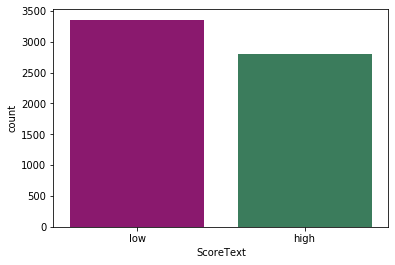

In [29]:
sns.countplot(x='ScoreText', data=df_viz, palette=workshop_palette)

ValueError: could not convert string to float: 'Male'

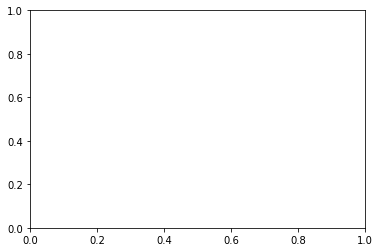

In [30]:
ax = sns.kdeplot(x="age", hue="sex", data=df_viz, palette=workshop_palette);
kdeline = ax.lines[0]
mean_fem = df_viz.groupby('sex').age.median()[0]
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()
height_fem = np.interp(mean_fem, xs, ys)
ax.vlines(mean_fem, 0, height_fem, color=purple, ls=':')

mean_m = df_viz.groupby('sex').age.median()[1]
height_m = np.interp(mean_m, xs, ys)
ax.vlines(mean_m, 0, height_m, color=green, ls=':')


print(df_viz.groupby('sex').age.median())

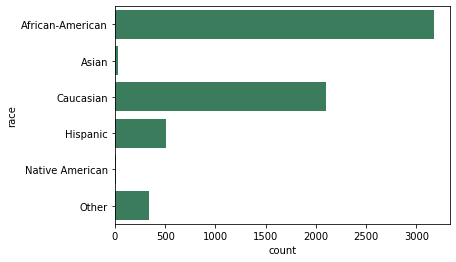

In [37]:
#@title Purpose plot

sns.countplot(y="race", data=df_viz, palette=["#30875c"])

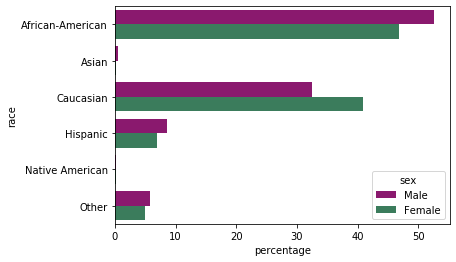

In [38]:
#@title Purpose plot by gender

occupation_counts = (df_viz.groupby(['sex'])['race']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('race'))
p = sns.barplot(y="race", x="percentage", hue="sex", data=occupation_counts, palette=workshop_palette)

In [39]:
#@title Purpose plot with the target variable

# from raw value to percentage
total_purpose = df_viz['race'].value_counts() \
                     .rename('percentage') \
                     .mul(100).reset_index().rename(columns={"index": "purpose"}).sort_values('race')

good_purpose = df_viz[df_viz['ScoreText'] == "good"]['race'].value_counts() \
                     .rename('percentage') \
                     .mul(100).reset_index().rename(columns={"index": "race"}).sort_values('race')


good_purpose['percentage'] = [i / j * 100 for i,j in zip(good_purpose['percentage'], total_purpose['percentage'])]
total_purpose['percentage'] = [i / j * 100 for i,j in zip(total_purpose['percentage'], total_purpose['percentage'])]

# bar chart 1 -> top bars (group of 'smoker=No')
bar1 = sns.barplot(y="race",  x="percentage", data=total_purpose, color='#9d0677')

# bar chart 2 -> bottom bars (group of 'smoker=Yes')
bar2 = sns.barplot(y="race", x="percentage", data=good_purpose, color='#30875c')

# add legend
top_bar = mpatches.Patch(color='#9d0677', label='low score')
bottom_bar = mpatches.Patch(color='#30875c', label='high score')
plt.legend(handles=[top_bar, bottom_bar])

# show the graph
plt.show()

KeyError: 'race'

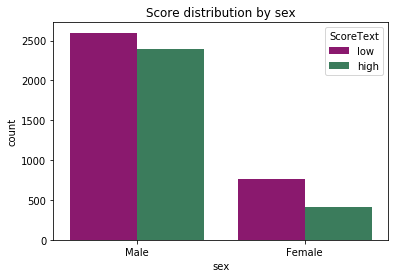

In [40]:
by_sex = sns.countplot(x="sex", hue="ScoreText", data=df_viz, palette=workshop_palette)

plt.title('Score distribution by sex')
plt.show()

In [41]:
##Metrics

from aif360.sklearn.preprocessing import ReweighingMeta, Reweighing

lr = LogisticRegression(solver='lbfgs')
rew = ReweighingMeta(estimator=lr, reweigher=Reweighing('sex'))
rew.fit(X_train, y_train)
y_pred_REW = rew.predict(X_test)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [42]:
acc_REW = accuracy_score(y_test, y_pred_REW)
print(f'[Reweighting] The test accuracy of the algorithm is: {acc_REW: .2%}')

[Reweighting] The test accuracy of the algorithm is:  58.88%


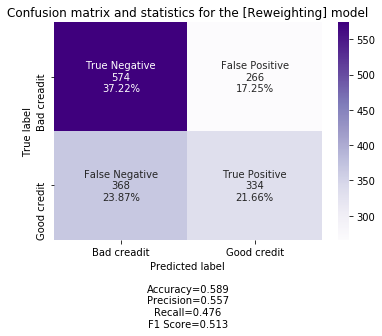

In [43]:
cf_matrix = confusion_matrix(y_test, y_pred_REW)
make_confusion_matrix(cf_matrix, "[Reweighting]")

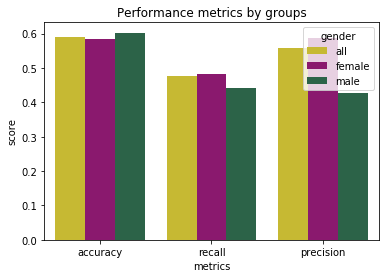

In [44]:
metrics_per_group(y_test, y_pred_REW)

In [45]:
stat_par_diff_RW = statistical_parity_difference(y_test, y_pred_REW, prot_attr='sex')
print(f'[Reweighting] The statistical parity difference is {stat_par_diff_RW: .2}')

[Reweighting] The statistical parity difference is  0.04


In [46]:
# rebalance the dataset using the algorithm in the paper
# train the model
# evalute model on the same metrics
eq_opp_diff_RW = equal_opportunity_difference(y_test, y_pred_REW, prot_attr='sex')

print(f'[Reweighting] The equal opportunity difference is {eq_opp_diff_RW: .2}')

[Reweighting] The equal opportunity difference is  0.04


In [47]:
gen_entr_error_RW = generalized_entropy_error(y_test, y_pred_REW, alpha=1)


print(f'[Reweighting] The generalized entropy error is {gen_entr_error_RW: .2}')

[Reweighting] The generalized entropy error is  0.32


In [48]:
plot_fair_metrics([stat_par_diff_RW, eq_opp_diff_RW, gen_entr_error_RW], 'Reweighting')

NameError: name 'stat_par_diff' is not defined

In [49]:
##Optimization Approach

# combine the features with the predicted label, and rename the sensitive attribute column

df_train = X_train.copy()
df_train["RawScore"] = y_train
df_train.rename(columns={51:'sex'}, inplace=True)
df_train = df_train.reset_index(drop=True)

df_test = X_test.copy()
df_test["RawScore"] = y_test
df_test = df_test.reset_index(drop=True)
df_test.rename(columns={51:'sex'}, inplace=True)

In [51]:
# To use AIF360's Disparate Impact Remover, we need to create a BinaryLabelDataset for the training and testing data
train_CD = CompasDataset(favorable_label='1',
                                unfavorable_label='0',
                                df=df_train,
                                label_names=['RawScore'],
                                protected_attribute_names=['sex'])

test_CD = CompasDataset(favorable_label='1',
                                unfavorable_label='0',
                                df=df_test,
                                label_names=['RawScore'],
                                protected_attribute_names=['sex'])

TypeError: __init__() got an unexpected keyword argument 'favorable_label'

In [52]:
meta = MetaFairClassifier(tau=0.8, sensitive_attr='sex', type='fdr', seed=1234567)

meta.fit(train_CD)
y_pred_META = meta.predict(test_BLD)
y_pred_META = y_pred_META.labels.flatten()

NameError: name 'train_CD' is not defined